<a href="https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Installing_TensorFlow_Object_Detection_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates the process of installing the [TensorFlow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) within your Colab notebook so that you can utilize Colab's incredible compute resources for free (TFOD API is indeed resource demanding).

The TensorFlow Object Detection API is an open-source framework built on top of TensorFlow that makes it easy to construct, train and deploy object detection models. I have often seen many individuals struggling to make use of this amazing library because of two reasons:
- The library is resource demanding. It needs decent GPU to train in a reasonable timeframe. 
- For students, it is not always possible to choose Cloud platforms to run TFOD API. Even if they are free platforms like [Google Cloud Platform](https://cloud.google.com) requires you to verify your identity with a credit card and in most cases, a student may not have that. 

This the motivation behind preparing this notebook. 

![](https://github.com/tensorflow/models/raw/master/research/object_detection/g3doc/img/kites_detections_output.jpg)
<center><a href="https://github.com/tensorflow/models/tree/master/research/object_detection">Source</a></center>

Before you can get started please make sure your runtime is proper:
- Go to the **Runtime** tab.
- Select **Change runtime type**.
- You should be seeing a prompt asking you to configure the prompt and it should look like so:
  
  ![](https://i.ibb.co/tqt3kK2/Screen-Shot-2019-09-05-at-12-18-55-PM.png)
  
- Click on **Save**. 

Now, you should be good to proceed. 

## Verify TensorFlow installation

In [0]:
# Verify TensorFlow installation
import tensorflow as tf
print(tf.__version__)

## OS-level dependencies

In [0]:
# OS-level dependencies
!apt-get install -y -qq protobuf-compiler python-pil python-lxml

## The repo containing the necessary files for the TFOD API

In [0]:
# The repo containing the necessary files for the TFOD API
!git clone https://github.com/tensorflow/models.git

In [0]:
# Change to the models/research directory
import os
os.chdir('models/research')

## Compile the Protobuffers

In [0]:
# Compile the Protobuffers
!protoc object_detection/protos/*.proto --python_out=.

## Add `slim` to the PYTHONPATH

In [0]:
# Add `slim` to the PYTHONPATH
import sys
sys.path.append('/content/models/research/slim')

In [0]:
# And voila!
%run object_detection/builders/model_builder_test.py

At this point, the TFOD API should have been installed and you should see the success message in running the tests. But due to `IPython` you may also see the following error:

```
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<ipython-input-8-31812fc4de3b> in <module>()
----> 1 get_ipython().magic('run object_detection/builders/model_builder_test.py')

5 frames
</usr/local/lib/python3.6/dist-packages/decorator.py:decorator-gen-58> in run(self, parameter_s, runner, file_finder)

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py in mpl_execfile(fname, *where, **kw)
    175         matplotlib.interactive(is_interactive)
    176         # make rendering call now, if the user tried to do it
--> 177         if plt.draw_if_interactive.called:
    178             plt.draw()
    179             plt.draw_if_interactive.called = False

AttributeError: 'function' object has no attribute 'called'
```

You can ignore this error and you can also double-check if the TFOD API was truly installed or not by running the following cell. It should run successfully in case the TFOD API was successfully installed. 

In [0]:
from object_detection.utils import ops as utils_ops

## Running inference using TFOD API

In this section, we will see how to take a pre-trained object detection model and use it for running inference. It follows [this example](https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb) provided by the TFOD team. But it also includes the necessary changes needed to conform to the Colab environment.

In [0]:
## Packages
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

In [0]:
# This is needed to display the images.
%matplotlib inline

In [0]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

## Variables' declaration

In [0]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'mscoco_label_map.pbtxt'

In [0]:
# Get the labels' mapping
!wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt

## Download Model

In [0]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

Let's retrieve and organize the test images.

In [0]:
!wget https://github.com/tensorflow/models/raw/master/research/object_detection/test_images/image1.jpg
!wget https://github.com/tensorflow/models/raw/master/research/object_detection/test_images/image2.jpg
!mkdir test_images
!mv *.jpg test_images/

In [0]:
# Verify
!ls test_images/

image1.jpg  image2.jpg


In [0]:
# Verify we are still on the right directory
!pwd

/content/models/research


## Detection

In [0]:
PATH_TO_TEST_IMAGES_DIR = 'object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

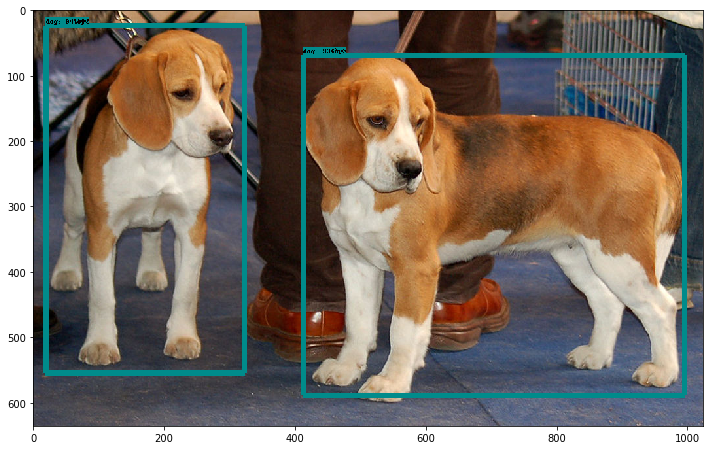

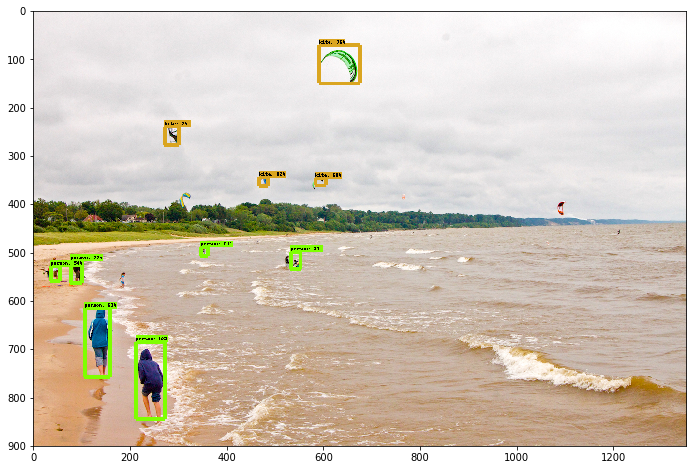

In [0]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

You can easily follow the instructions from [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_locally.md) to run custom training jobs (with your custom datasets) in Colab environment now. Here are some of my personal recommendations while you do so - 
- Please note that there is always a chance of crash when you are working in a Colab enviornment (like many other environments) but the main problem here is you will lose all your data (which will not happen if you are on a persistent storage enabled environment). So, in order to reduce that cost, it is always better to keep your data safe in Drive and mount that in the Colab environment. 
- It's better to keep the data preparation part segregated from the training pipeline. Maintain a separate notebook when you are preparing the data for the TFOD API, retrieve the `.tfrecord` files in another notebook where you will be running the training jobs. That way you will be able to maintain a clean codebase. 

## References:
- TensorFlow Object Detection API official documentation: https://github.com/tensorflow/models/tree/master/research/object_detection

I have used TensorFlow Object Detection API in a number of projects and all of them can be checked [here](https://devmesh.intel.com/users/sayak-paul). 